# Churn Risk Prediction for Retail Customer Retention

**Objective:**  
Identify customers at risk of churn using transactional behaviour and build a decision-ready churn risk model to support targeted retention strategies.

**Context:**  
In non-subscription retail, churn is not explicitly labelled. This project applies a forward-looking, snapshot-based definition of churn to create a realistic and defensible prediction framework.


## 1. Business Problem

Retail marketing teams face a recurring challenge:  
**Which customers are likely to disengage, and how can limited retention budgets be prioritised effectively?**

Unlike subscription businesses, retail datasets rarely contain explicit churn labels.  
Instead, churn must be inferred from **prolonged inactivity**.

This project addresses the question:

> *“Which customers are at highest risk of not returning, based on their historical purchasing behaviour?”*

The output is a **prioritised list of at-risk customers** with interpretable risk drivers.


## 2. Data Overview

- **Source:** Online Retail II dataset
- **Period:** 2009–2011
- **Granularity:** Transaction-level retail data
- **Key Fields:** Invoice date, customer ID, quantity, unit price, country

The dataset captures historical purchasing behaviour suitable for behavioural churn modelling.


## 3. Data Preparation

The dataset is cleaned to:
- Remove missing customer identifiers
- Remove cancelled or negative-value transactions
- Create total transaction value


In [12]:
import pandas as pd
import numpy as np

df = pd.read_excel("online_retail_II.xlsx")

df = df.drop(columns=["Unnamed: 0"])

df.columns = (
    df.columns
    .str.strip()
    .str.replace(" ", "_")
)

df = df.rename(columns={"Price": "UnitPrice"})

df = df.dropna(subset=["Customer_ID"])
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Customer_ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## 4. Churn Definition

Because churn is not explicitly labelled, an **industry-standard proxy** is applied.

### Definition Used:
- A **snapshot date** is selected.
- A customer is considered **churned** if they make **no purchases in the 90 days following the snapshot**.

### Why 90 Days?
- Typical retail purchase cycles occur within 30–60 days
- 90 days balances false positives and missed churn
- Maintains statistical power while reflecting meaningful disengagement

This approach avoids label leakage and mirrors real-world prediction scenarios.


## 5. Feature Engineering

To predict churn, transaction-level data is aggregated into **customer-level behavioural features**.

All features are computed **using data prior to the snapshot date only**, ensuring the model does not use future information.

The following features are constructed:

- **Recency**: Days since the customer’s last purchase
- **Frequency**: Number of unique purchase occasions
- **Monetary Value**: Total historical spend
- **Average Order Value**: Mean transaction value

These features are widely used in customer analytics and are easily interpretable by business stakeholders.


In [13]:
from datetime import timedelta

snapshot_date = df["InvoiceDate"].max() - timedelta(days=90)
horizon_days = 90

df_hist = df[df["InvoiceDate"] <= snapshot_date].copy()

customer_features = (
    df_hist.groupby("Customer_ID")
    .agg(
        last_purchase=("InvoiceDate", "max"),
        frequency=("Invoice", "nunique"),
        monetary=("TotalPrice", "sum"),
        avg_order_value=("TotalPrice", "mean"),
    )
    .reset_index()
)

customer_features["recency_days"] = (
    snapshot_date - customer_features["last_purchase"]
).dt.days

customer_features.head()


,Customer_ID,last_purchase,frequency,monetary,avg_order_value,recency_days
0,12346.0,2010-06-28 13:53:00,11,372.86,11.298788,74
1,12349.0,2010-05-18 09:57:00,2,1268.52,26.989787,115
2,12355.0,2010-05-21 11:59:00,1,488.21,22.191364,112
3,12358.0,2010-06-07 12:28:00,2,1697.93,48.512286,95
4,12359.0,2010-06-22 10:24:00,5,2012.03,23.395698,80


## 6. Churn Label Construction

A forward-looking churn label is constructed to reflect how churn prediction is used in practice.

A customer is labelled as **churned** if they make **no purchases in the 90 days following the snapshot date**.

This approach ensures:
- No leakage of future information into feature engineering
- Realistic simulation of a production deployment scenario
- Alignment with industry-standard churn modelling practices


In [14]:
from datetime import timedelta

df_future = df[
    (df["InvoiceDate"] > snapshot_date) &
    (df["InvoiceDate"] <= snapshot_date + timedelta(days=horizon_days))
].copy()

future_buyers = set(df_future["Customer_ID"].unique())

customer_features["churned_next_90d"] = (
    ~customer_features["Customer_ID"].isin(future_buyers)
).astype(int)

customer_features["churned_next_90d"].value_counts(normalize=True)


churned_next_90d
0    0.575067
1    0.424933
Name: proportion, dtype: float64

## 7. Modelling Approach

A **logistic regression model** is used to estimate customer churn risk.

This model is selected because:
- It is interpretable and stable
- Coefficients can be directly translated into business insights
- It performs well for binary classification with limited behavioural features

Given moderate class imbalance, class weighting is applied instead of resampling to preserve the original data distribution.

Model performance is evaluated using **ROC AUC**, which measures the model’s ability to correctly rank customers by churn risk rather than relying solely on accuracy.


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

features = ["recency_days", "frequency", "monetary", "avg_order_value"]
X = customer_features[features]
y = customer_features["churned_next_90d"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.74      0.58      0.65       389
           1       0.56      0.72      0.63       287

    accuracy                           0.64       676
   macro avg       0.65      0.65      0.64       676
weighted avg       0.66      0.64      0.64       676

ROC AUC: 0.7200720152629363


## 8. Model Training and Evaluation

A logistic regression model is trained to predict the probability that a customer will churn in the next 90 days.

### Evaluation Metrics
- **ROC AUC:** Measures how well the model ranks customers by churn risk (higher is better).
- **Precision (Churn):** Of customers flagged as at risk, how many actually churn.
- **Recall (Churn):** Of customers who churn, how many the model successfully identifies.

In retention use-cases, **recall is often prioritised** to avoid missing high-risk customers, even if some false positives occur.


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

features = ["recency_days", "frequency", "monetary", "avg_order_value"]
X = customer_features[features]
y = customer_features["churned_next_90d"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.74      0.58      0.65       389
           1       0.56      0.72      0.63       287

    accuracy                           0.64       676
   macro avg       0.65      0.65      0.64       676
weighted avg       0.66      0.64      0.64       676

ROC AUC: 0.7200720152629363


### Interpretation of Results

The model produces a probability score for each customer. Performance is assessed by:
- Whether churners can be ranked above non-churners (ROC AUC)
- Whether the model can identify a meaningful proportion of churners (recall)

The default threshold (0.5) is used as a baseline. In a real retention setting,
the threshold would be adjusted based on capacity and the cost of interventions.


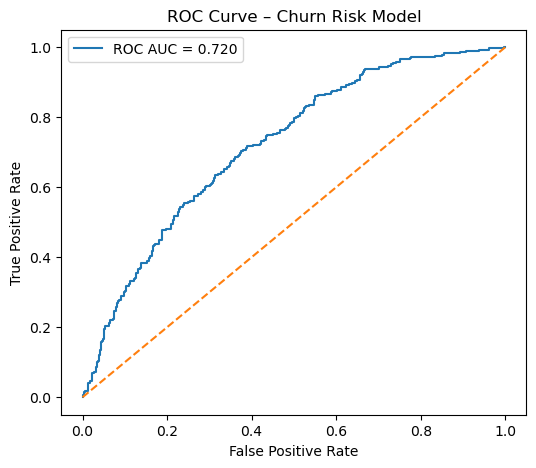

In [17]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Churn Risk Model")
plt.legend()
plt.show()


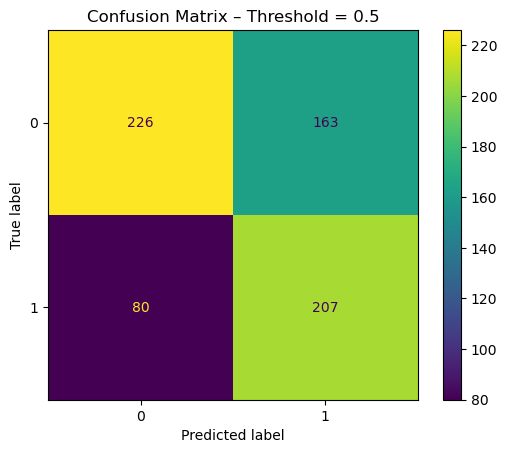

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix – Threshold = 0.5")
plt.show()


## 9. Model Interpretation

Beyond predictive performance, the value of a churn model lies in its interpretability.
Understanding *why* customers are at risk enables targeted, cost-effective retention actions.

Logistic regression coefficients are examined to identify which behavioural factors
most strongly influence churn risk.

Positive coefficients indicate **higher likelihood of churn**.
Negative coefficients indicate **protective behaviours**.


In [19]:
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_[0]
}).sort_values("Coefficient", ascending=False)

coef_df


,Feature,Coefficient
0,recency_days,0.003385
3,avg_order_value,0.001175
2,monetary,-0.000111
1,frequency,-0.212982


### Key Drivers of Churn Risk

The model highlights clear behavioural signals:

- **Recency (days since last purchase)** is the strongest predictor of churn,
  confirming that disengagement is the primary risk signal.
- **Lower purchase frequency** increases churn likelihood, indicating weakening
  customer habits over time.
- **Lower monetary value and average order value** are associated with higher churn,
  suggesting reduced customer commitment.

These insights align with established customer lifecycle theory and provide
clear levers for retention strategy design.


## 10. Business Application & Next Steps

### How This Model Would Be Used in Practice

In a real retail environment, this model would be deployed to:

- Generate **weekly or monthly churn risk scores**
- Rank customers by predicted churn probability
- Prioritise retention interventions for the highest-risk segment

Rather than contacting all customers, resources can be focused where
intervention is most likely to prevent revenue loss.


### Example Retention Actions

| Risk Profile | Recommended Action |
|-------------|-------------------|
| High recency + declining frequency | Reminder campaigns, personalised offers |
| Low monetary value | Bundles or threshold-based incentives |
| Previously high-value customers | Proactive outreach or loyalty rewards |

Thresholds would be adjusted based on:
- Retention team capacity
- Cost of incentives
- Customer lifetime value


### Limitations

- Churn is defined using an inactivity proxy rather than explicit labels
- No marketing or engagement data is available
- Product-level behaviour is not explicitly modelled

### Potential Improvements

- Segment-specific churn models
- Time-to-event (survival) analysis
- Integration with RFM or CLV models
- Dynamic threshold optimisation based on ROI


## Conclusion

This project demonstrates a **business-first approach to predictive modelling**:
- Realistic problem framing
- Defensible assumptions
- Interpretable models
- Actionable outputs

The result is not just a churn prediction model,
but a decision-support tool suitable for real-world deployment.
